# SYDE 552 Assignment 3: Hippocampal Models
### Due March 18, Anywhere on Earth 
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with associative memories. To do so, we'll be using pytorch to implement different associative memory models.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Hippocampus

**1.a) [2 marks]** The hippocampus is implicated in spatial navigation and episodic memory.  How do we know this?  What are some of the neuroscience results that revealed these facilities of the hippocampus?  (see Kandel *et al.* Ch. 65)

We know this primarily through the studying of the impact of lesions on the hippocampus and greater medial temportal lobe. Through cases such as that of H.M. and R.B., we see a clear impairment of episodic and long-term memory due to hippocampal and local damage. Additionally, studies involving mice and rats have employed lesioning to the hippocampus and have observed a clear impairment to spatial recollection and processing. From a more clinical perspective, fMRI data of people recalling spatial information has shown an increase in activity to the right hippocampus -- indicating the the hippocampus plays some key role in spatial navigation and episodic memory.

**1.b) [2 marks]** The Gluck and Meyers model of hippocampus is a simple, effective model of hippocampus, and how representations may be constructed for the slow transfer to the neocortex.  However, it still has its limitations.  Explain some (two or more) of the limitations of the Gluck and Meyers model.  (The Gluck and Meyers Ch.6 reading will be useful in answering this question.) 

The Gluck and Meyers model suffers from both functional and implementation-specific limitations:
 1. The Cortico-Hippocampal Model lacks key functionalities of the Hippocampus, such as spatial and declarative memory. For one, the model is unable to learn and effectively encode spatial information -- something we observe in the Hippocampus with place cells -- and is unable to facilitate recallable memory. It is implemented more for conditioned, associative memory.
 2. The Cortico-Hippocampal Model lacks some key attributes of hippocampal processes, such as habituation/extinction of conditioned responses and temporal trace processing. Since the model does not consider temporal relationships of stimuli, a conditioned response following an unconditioned stimuli with some pause is effectively lost. The model lacks a way to factor temporal information into its conditioning. With respect to extinction, it is typical that a stream of conditioned stimuli will reduce the effectiveness and poignancy of conditioned responses, causing the association to reduce and perhaps even become extinct.

**1.c) [2 mark]** Unsupervised pre-training is integral to the Gluck and Meyers model of Hippocampus, and unsupervised pre-training has been shown to accelerate reinforcement learning in rats navigating mazes.  However, unsupervised pre-training is not common in deep learning techniques.  Describe why that may be.  (See [$\S 15.1$ of Goodfellow *et al.*](https://www.deeplearningbook.org/contents/representation.html))

Unsupervised pre-training (UPT) has a lot of variability in how it impacts a given model. Based on the provided reading, UPT has been observed to, at times, result in a worse model than if UPT were not performed at all. The use of UPT also breaks up training into two distinct phases with a requirement for additional hyperparameters that are not jointly tunable. Because of the distinct hyperparameters, it is difficult to understand how the tuning of one training may or will impact the tuning of another and how they jointly will affect the model being trained. UPT is also unable to flexibly alter regularization in training, leading to a more rigid and less forgiving training setup. It has been largely abandoned aside from the domain of NLP, where it is more appropriately used to pre-process embeddings of tokens.

# 2. Hopfield Networks

## Preliminaries

Although you should have installed them for prior assignments, we will require the pytorch and keras. Let's install those now/

```pip install torch keras```

Next, we will download the MNIST dataset.  We will do this through the Keras library instead of torchvision.

Some people have been having problems with the code in the next block due to certificate errors.  If you do have this problem, try using the following code:

```python
import ssl
import keras.datasets.mnist
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
```

I don't recommend doing this if you don't have too - ignoring certificate errors is bad security practice.

In [1]:
import keras.datasets.mnist
import torch
import numpy as np
import copy
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

2024-03-18 15:43:37.265051: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 15:43:37.755833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 15:43:38.980390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


As before, we will examine some of the images to make sure we got them right.

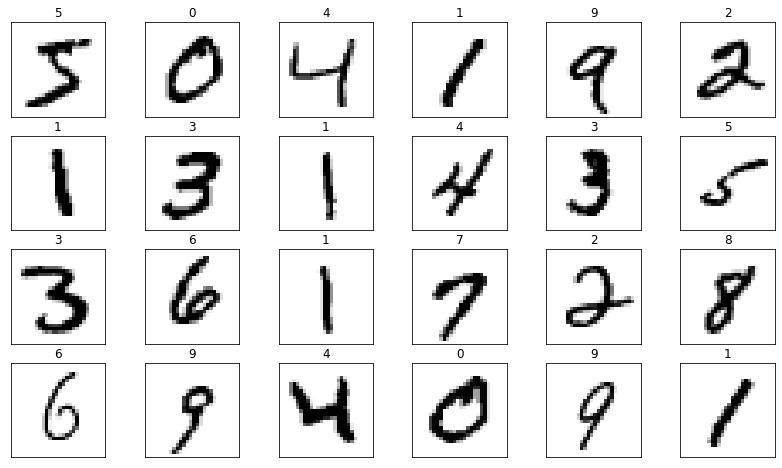

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape((28,28)), vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

Normally, the MNIST dataset has images represented by values in the range $[0,255]$. However, since we are dealing with Hopfield networks, we are going to binarize the data.

In [3]:
def binarize(xs):
    '''
    xs : a num_samples by num_features array of images.
    '''
    binary = (xs / 255) > 0.5
    integer = 2 * binary - 1
    return integer

binary_imgs = binarize(x_train)

Further, to make things easy on our network, we are only going to look at images of the digits 0, 1, and 2

In [4]:
binary_imgs = binary_imgs[y_train < 3,:]

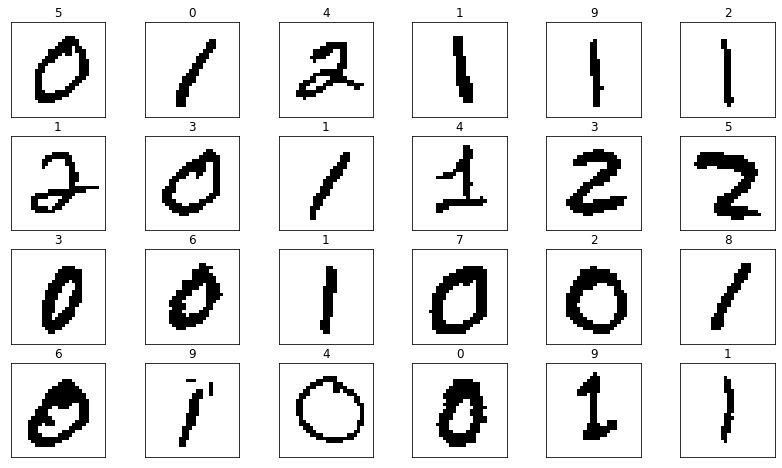

In [7]:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

We will also need to reshape the data into a vector representation, and then covert it to a pytorch tensor

In [8]:
binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)


**2.a) [2 Marks]**  Implement the Hopfield Network using Hopfield's learning rule.

We will first implement the Hopfield network using the outer product formulation for the weight matrix.  Given a set of patterns $\mathbf{x}_{i}$, by first computing the matrix

$$D = \frac{1}{N}\sum_{i}^{N} (\mathbf{x}_{i}-\theta)(\mathbf{x}_{i}-\theta)^T$$.

where $\theta = \frac{1}{ND}\sum_{i}^{N}\sum_{j}^{D} x_{i,j}$, i.e., the average value of all elements in the training data.

Next we remove the diagonal element of the matrix, making the weight matrix:

$$
W = D - \mathrm{diag}(D),
$$

where $\mathrm{diag}(D)$ is the diagonal of the $D$ matrix.  Note that when implementing this in numpy or pytorch we must apply the ```diag``` function twice, i.e.:

```
W = D - torch.diag(torch.diag(D))

```

Here is some code to implement the learning rule:

In [9]:
def outer_product_hopfield_matrix(training_patterns):
    '''
    train_hopfield_matrix - produces a matrix for a (non-Modern) Hopfield network using the outer product rule.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
    
        A Tensor of shape (num_patterns, num_features) that will be used to construct the weight matrix.
        
    Returns:
    --------
    
    W : torch.Tensor
    
        A (num_features, num_features) Tensor that stores the papers encoded in the network.
    '''
    
    theta = torch.sum(training_patterns) / (training_patterns.shape[0] * training_patterns.shape[1])
    D = torch.einsum('nd,ne->de', training_patterns - theta, training_patterns - theta) / float(training_patterns.shape[0])
    W = (D - torch.diag(torch.diag(D))) 
    return W
    
def evaluate_hopfield_network(W, input_pattern, training_patterns=None, num_iters = 5, threshold=0):
    '''
    Evaluates a Hopfield network with weight matrix W on a number of tets patterns.  Also computed the similarity 
    '''
    
    assert input_pattern.shape[1] == 1, f'''This function assumes you are cleaning up one pattern at a time. 
                                            Expected the input to be shape (1,{input_pattern.shape[1]}), 
                                            got {input_pattern.shape}'''
    s = input_pattern
    
    similarities = None
    if training_patterns is not None:
        similarities = torch.zeros((num_iters, training_patterns.shape[0]))
    ### end if
    
    for i in range(num_iters):
        s = torch.sign(W @ s - threshold)
        
        if training_patterns is not None:
            similarities[i,:] = torch.einsum('d,nd->n',s,training_patterns)
        ### end if
    ### end for
    return s, similarities

We want you to do the following things:

1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.
2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.
3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.
4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **testing** images and compute the testing error as the probability of noise increases.  Note: Compare the reconstructed images to the non-noisy images, e.g., for any test image you would do something like:

```python
noisy_image = corrupt(test_image, noise_level)
reconstructed_images = evaluate_hopfield_network(W, noisy_image.T)
error = mse(reconstructed_images, test_images)
```

In [10]:
## 2.a.1 - Compute network capacity.
C = torch.round(28**2 / (2 * torch.log2(torch.IntTensor([28**2])))).to(torch.int)
print(C)

tensor([41], dtype=torch.int32)


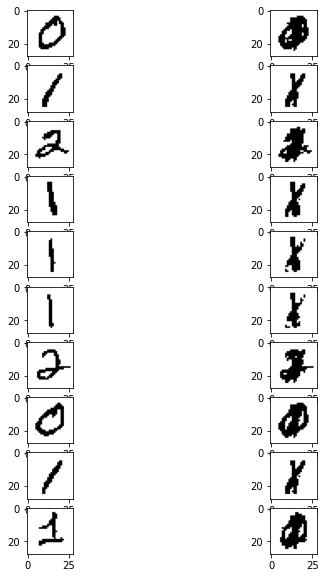

In [11]:
# 2.a.2 - plot original and reconstructed imatges.
plt.figure(figsize=(8,10))
# create weight matrix, W
pattern_sample = binary_img_tensor[:10,:]
W = outer_product_hopfield_matrix(pattern_sample)
for i in range(10):
    # reconstruct training image, i.
    plt.subplot(10,2,1+2*i)
    plt.imshow(pattern_sample[i].reshape((28,28)), cmap='gray_r')
    plt.subplot(10,2,1+2*i+1)
    plt.imshow((torch.sign(pattern_sample[i] @ W)).reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

As the number of network patterns increase, there is an increase in training error, though we do see a decrease in testing error.
This indicates that the network is becoming more generalizable to the greater dataset and less over-fit to the training dataset.


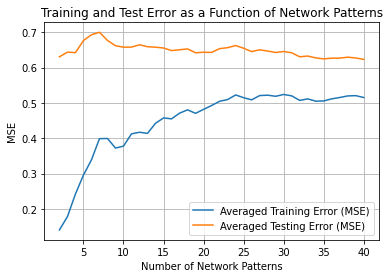

In [12]:
# 2.a.3 - Plot training and test error

def mse(true_vals, pred_val):
    return torch.mean(torch.pow(true_vals - pred_val,2))

def test_network(training_patterns, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros(len(range(2,C)))
    test_error = torch.zeros(len(range(2,C)))
    for cap_val in range(2,C):
        ## NOTE: you will need to change the following line if you want to use something other
        ## than the outer product matrix.
        W = outer_product_hopfield_matrix(training_patterns[:cap_val,:])
        for train_idx in range(cap_val):
            training_error[cap_val - 2] += mse(training_patterns[train_idx,:], torch.sign(training_patterns[train_idx,:] @ W)) / cap_val
        for test_idx in range(test_patterns.shape[0]):
            test_error[cap_val - 2] += mse(test_patterns[test_idx,:], torch.sign(test_patterns[test_idx,:] @ W)) / test_patterns.shape[0]
    return training_error, test_error

avg_train = torch.zeros(len(range(2,C)))
avg_test = torch.zeros(len(range(2,C)))

all_idxs = torch.Tensor(range(binary_img_tensor.shape[0]))
test_idxs = torch.multinomial(all_idxs, C.item())
all_idxs[test_idxs] = -1
all_idxs = all_idxs[all_idxs != -1]

for _ in range(5):
    unique_idxs = all_idxs[torch.multinomial(all_idxs, C.item())].to(int)
    train_idxs = unique_idxs   
    
    train, test = test_network(binary_img_tensor[train_idxs,:], binary_img_tensor[test_idxs,:],C)
    avg_train += train / 5
    avg_test += test / 5
#idxs = torch.multinomial(torch.Tensor(range(binary)), capacity)
plt.figure()
plt.plot(range(2,C), avg_train, label="Averaged Training Error (MSE)")
plt.plot(range(2,C), avg_test, label="Averaged Testing Error (MSE)")
plt.xlabel("Number of Network Patterns")
plt.ylabel("MSE")
plt.title("Training and Test Error as a Function of Network Patterns")
plt.grid()
plt.legend()

print('''As the number of network patterns increase, there is an increase in training error, though we do see a decrease in testing error.
This indicates that the network is becoming more generalizable to the greater dataset and less over-fit to the training dataset.''')

It seems that the hopfield network maintains its performance relatively well for some small amount of noise (P(change) < 30%), but it exponentially increases in error past a certain point


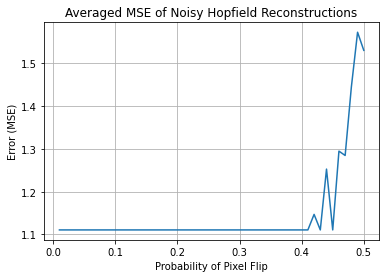

In [13]:
# 2.a.4 - Test salt-and-pepper noise.

def corrupt(ims_in, p):
    ims = copy.deepcopy(ims_in)
    out_ims = torch.zeros((ims.shape))
    for im_idx in range(ims.shape[0]):
        flip_idxs = torch.multinomial(torch.Tensor(range(784)),(784 * p).to(int))
        out_ims[im_idx] = ims[im_idx]
        out_ims[im_idx,flip_idxs] = out_ims[im_idx,flip_idxs] * -1
    return out_ims

num_steps = 50 # for the vibes
prob_flip = torch.linspace(0.01,0.5,num_steps)

all_idxs = torch.Tensor(range(binary_img_tensor.shape[0]))
all_idxs = torch.multinomial(all_idxs, 20)
train_idxs = all_idxs[:10]
test_idxs = all_idxs[10:]

training_data = binary_img_tensor[train_idxs,:]
testing_data = binary_img_tensor[test_idxs,:]
W = outer_product_hopfield_matrix(training_data)

mses_p = torch.zeros((num_steps))
for _ in range(5): # Averaged across 5 executions for good readings
    for p_idx, p in enumerate(prob_flip):
        noisy_testing = corrupt(testing_data,p)
        recon_set = torch.Tensor()
        for im_idx in range(noisy_testing.shape[0]):
            recon, _ = evaluate_hopfield_network(W, noisy_testing[im_idx,:].reshape(-1,1))
            recon_set = torch.cat((recon_set, recon))
        mses_p[p_idx] += mse(testing_data.reshape((-1,1)), recon_set) / 5
    
plt.figure()
plt.plot(prob_flip, mses_p)
plt.grid()
plt.title('Averaged MSE of Noisy Hopfield Reconstructions')
plt.xlabel('Probability of Pixel Flip')
plt.ylabel('Error (MSE)')

print("It seems that the hopfield network maintains its performance relatively well for some small amount of noise (P(change) < 30%), but it exponentially increases in error past a certain point")

**2.b) [2 Mark]** Train Hopfield network using the pseudo-inverse and repeat the tasks 2.a) 2-4, however, for this example, ensure the threshold value is 0.  Even though the pseudo-inverse has a greater capacity thant he hopfield network, we will still test up to the theoretical capcity of the Hopfield learning rule.

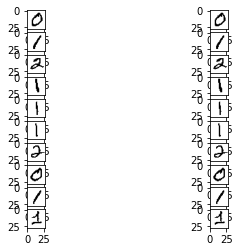

In [14]:
torch.manual_seed(12345)

def pseudo_inv(X, lamb=0.01):
    '''
    pseudo_inv - Implements the pseudoinverse from the previous assignment.
    
    Parameters:
    -----------
    
    X : torch.Tensor
        A (num_patterns, num_features) Tensor holding the training data.
        
    lamb : float
        The regularization term for the pseudoinverse
        
    
    Returns:
    --------
    
    The pseudoinverse of X
    '''
    return torch.inverse(X.T@X + lamb * torch.eye(X.shape[1]).float()) @ X.T

def pseudoinverse_hopfield_matrix(training_patterns, lamb = 0.01):
    '''
    pseudoinverse_hopfield_matrix - Uses the regularized pseudoinverse to construct a weight matrix for
        a non-modern Hopfield network.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
        
        The (num_patterns, num_features) Tensor containing the training data.
        
    lamb : float
    
        The regularization term for the pseudo-inverse. 
        
    Returns:
    --------
    
        The weight matrix compatible with the evaluate_hopfield_network function 
    '''
    W = pseudo_inv(training_patterns, lamb=lamb) @ training_patterns
    return W / training_patterns.shape[0]

W = pseudoinverse_hopfield_matrix(binary_img_tensor[:10,:])
for i in range(10):
    # reconstruct training image, i.
    plt.subplot(10,2,1+2*i)
    plt.imshow(pattern_sample[i].reshape((28,28)), cmap='gray_r')
    plt.subplot(10,2,1+2*i+1)
    plt.imshow((torch.sign(pattern_sample[i] @ W)).reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

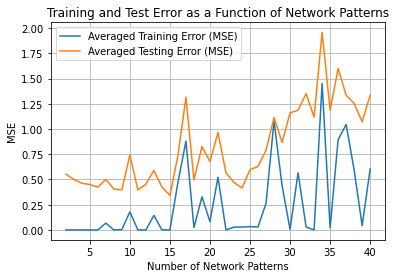

In [15]:
torch.manual_seed(12346)

def test_inv_network(training_patterns, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros(len(range(2,C)))
    test_error = torch.zeros(len(range(2,C)))
    for cap_val in range(2,C):
        ## NOTE: you will need to change the following line if you want to use something other
        ## than the outer product matrix.
        W = pseudoinverse_hopfield_matrix(training_patterns[:cap_val])
        for train_idx in range(cap_val):
            training_error[cap_val - 2] += mse(training_patterns[train_idx,:], torch.sign(training_patterns[train_idx,:] @ W)) / cap_val
        for test_idx in range(test_patterns.shape[0]):
            test_error[cap_val - 2] += mse(test_patterns[test_idx,:], torch.sign(test_patterns[test_idx,:] @ W)) / test_patterns.shape[0]
    return training_error, test_error

avg_train = torch.zeros(len(range(2,C)))
avg_test = torch.zeros(len(range(2,C)))

all_idxs = torch.Tensor(range(binary_img_tensor.shape[0]))
test_idxs = torch.multinomial(all_idxs, C.item())
all_idxs[test_idxs] = -1
all_idxs = all_idxs[all_idxs != -1]

for _ in range(5):
    unique_idxs = all_idxs[torch.multinomial(all_idxs, C.item())].to(int)
    train_idxs = unique_idxs   
    
    train, test = test_inv_network(binary_img_tensor[train_idxs,:], binary_img_tensor[test_idxs,:],C)
    avg_train += train / 5
    avg_test += test / 5

plt.figure()
plt.plot(range(2,C), avg_train, label="Averaged Training Error (MSE)")
plt.plot(range(2,C), avg_test, label="Averaged Testing Error (MSE)")
plt.xlabel("Number of Network Patterns")
plt.ylabel("MSE")
plt.title("Training and Test Error as a Function of Network Patterns")
plt.grid()
plt.legend()

Similar to the outer product matrix, the pseudoinverse matrix results in a hopfield network that responds relatively well to small amounts of noise in the input images.
Compared to the outer product matrix, the pseudoinverse produces a larger error for smaller probabilities, and the error increases more quickly as the probability increases.


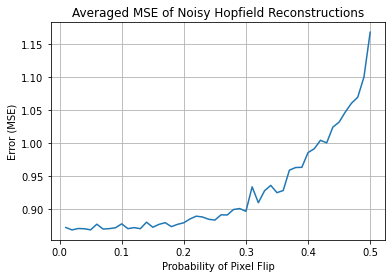

In [16]:
torch.manual_seed(12345)

num_steps = 50 # for the vibes
prob_flip = torch.linspace(0.01,0.5,num_steps)

all_idxs = torch.Tensor(range(binary_img_tensor.shape[0]))
all_idxs = torch.multinomial(all_idxs, 20)
train_idxs = all_idxs[:10]
test_idxs = all_idxs[10:]

training_data = binary_img_tensor[train_idxs,:]
testing_data = binary_img_tensor[test_idxs,:]
W = pseudoinverse_hopfield_matrix(training_data)

mses_p = torch.zeros((num_steps))
for _ in range(5): # Averaged across 5 executions for good readings
    for p_idx, p in enumerate(prob_flip):
        noisy_testing = corrupt(testing_data,p)
        recon_set = torch.Tensor()
        for im_idx in range(noisy_testing.shape[0]):
            recon, _ = evaluate_hopfield_network(W, noisy_testing[im_idx,:].reshape(-1,1))
            recon_set = torch.cat((recon_set, recon))
        mses_p[p_idx] += mse(testing_data.reshape((-1,1)), recon_set) / 5
    
plt.figure()
plt.plot(prob_flip, mses_p)
plt.grid()
plt.title('Averaged MSE of Noisy Hopfield Reconstructions')
plt.xlabel('Probability of Pixel Flip')
plt.ylabel('Error (MSE)')

print('''Similar to the outer product matrix, the pseudoinverse matrix results in a hopfield network that responds relatively well to small amounts of noise in the input images.
Compared to the outer product matrix, the pseudoinverse produces a larger error for smaller probabilities, and the error increases more quickly as the probability increases.''')

##### **2.c) [1 Mark]** Show how the network behaves when an entire region of the image is corrupted. 

For your best performing network, take three test images and set half of the inputs to be equal to zero.  
Plot the original images, the corrupted images, and the reconstructed images, side-by-side.

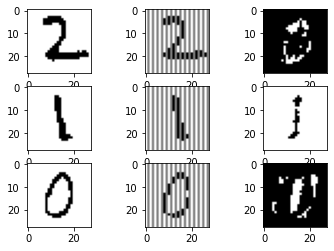

In [17]:
torch.manual_seed(5)

# Based on the above plot, Outer Product Matrix seems to perform better given the assumed capacity
all_idxs = torch.Tensor(range(binary_img_tensor.shape[0]))
sampled_idx = torch.multinomial(all_idxs, 3)
sampled_pattern = binary_img_tensor[sampled_idx,:]
corrupted_pattern = copy.deepcopy(sampled_pattern)
corrupted_pattern[:,1::2] = 0

all_idxs = torch.Tensor(range(binary_img_tensor.shape[0]))
training_idxs = torch.multinomial(all_idxs, C.item()).to(int)
W1 = outer_product_hopfield_matrix(binary_img_tensor[training_idxs,:])
W2 = pseudoinverse_hopfield_matrix(binary_img_tensor[training_idxs,:])

f, ((pl1, pl2, pl3), (pl4, pl5, pl6), (pl7, pl8, pl9)) = plt.subplots(3,3)

pl1.imshow(sampled_pattern[0,:].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
pl2.imshow(corrupted_pattern[0,:].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
pl3.imshow(torch.sign(corrupted_pattern[0,:] @ W2).reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

pl4.imshow(sampled_pattern[1,:].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
pl5.imshow(corrupted_pattern[1,:].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
pl6.imshow(torch.sign(corrupted_pattern[1,:] @ W2).reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

pl7.imshow(sampled_pattern[2,:].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
pl8.imshow((corrupted_pattern[2,:]).reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
pl9.imshow(torch.sign(corrupted_pattern[2,:] @ W2).reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')




# 3. Autoencoders

Now we are going to train an autoencoder to perform the same associative task that we explored above.  We are going to define our Autoencoder using sigmoid neurons, which shouldn't be too terrible, since it is a relatively shallow network, but one is not obligated to use those. 

Because we are going to use a sigmoidal output function, so we should be concerned with values in the range $[0,1]$, instead of $\{-1,1\}$.  Training will be done using the original MNIST images, **not** the binary images.


In [18]:
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.from_numpy(x_train.reshape((-1,28*28)).astype(np.float32) / 255)
x_test_tensor = torch.from_numpy(x_test.reshape((-1,28*28)).astype(np.float32) / 255)

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [19]:
class Autoencoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Sigmoid activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, num_hidden),
            torch.nn.Sigmoid(),            
        )
         
        # Building an linear decoder with Linear
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(num_hidden, num_inputs),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [20]:
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        epoch_loss = []
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.mse_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            epoch_loss.append(loss.detach().numpy())
            # print('Epoch Loss: ', np.array(epoch_loss).squeeze())

    # update the list of training accuracy values
    training_loss.append(np.mean(epoch_loss)) # store the loss for later.
    print('Iteration', len(training_loss), 'Training loss:', training_loss[-1])
    
    correct = 0
    network.eval()
    test_set_loss = []
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        loss = F.mse_loss(output, target)
        test_set_loss.append(loss.detach().numpy())
        
        
    # update the list of testing accuracy values
    testing_loss.append(np.mean(test_set_loss))
    print('Iteration', len(testing_loss), 'Testing loss:', testing_loss[-1])

**3.1 [2 Marks]** For the autoencoder we will do the following:

1. Train the network and plot the testing and training losses(repeated trials) for 5 different different values of the hidden layer size.  **Ensure the number of hidden layers is always less than the number of input features**.  Select a good number of training iterations (i.e., not overfitting) and a good number of hidden neurons
2. Plot 10 input and reconstructed images from the training set and 10 from the testing set.  How do these compare to the reconstructions of from the Hopfield networks you constructed above?
3. With your trained network, compare the loss on inputs corrupted salt and pepper noise.  Sweep through a range of number of pixels corrupted from 0 to 75\%.  Because the image data is back in the range $[0,1]$, this time corrupt the image by setting pixels to equal 0 or 1 with 50\% probability.

In [21]:
torch.manual_seed(12345)

layers = [10, 50, 100, 200, 400]
results = [[],[],[],[],[]]
nets = [[],[],[],[],[]]

for n_idx, n in enumerate(layers):
    network = Autoencoder(784,n)
    training_loss = []
    testing_loss = []

    # We're all hip, fashionable people here, let's use the Adam optimizer.
    optimizer = torch.optim.Adam(network.parameters(), lr = 1e-2)
    for _ in range(7):
        continue_training()
    nets[n_idx] = copy.deepcopy(network)
    results[n_idx] = [training_loss, testing_loss]

Iteration 1 Training loss: 0.067317806
Iteration 1 Testing loss: 0.06751829
Iteration 2 Training loss: 0.067296706
Iteration 2 Testing loss: 0.067530945
Iteration 3 Training loss: 0.067304
Iteration 3 Testing loss: 0.06754704
Iteration 4 Training loss: 0.06729043
Iteration 4 Testing loss: 0.067510486
Iteration 5 Training loss: 0.06729426
Iteration 5 Testing loss: 0.06751121
Iteration 6 Training loss: 0.06729622
Iteration 6 Testing loss: 0.067503326
Iteration 7 Training loss: 0.06729277
Iteration 7 Testing loss: 0.067505926
Iteration 1 Training loss: 0.028498946
Iteration 1 Testing loss: 0.0277031
Iteration 2 Training loss: 0.023960149
Iteration 2 Testing loss: 0.023444964
Iteration 3 Training loss: 0.016607912
Iteration 3 Testing loss: 0.015982796
Iteration 4 Training loss: 0.0130952895
Iteration 4 Testing loss: 0.012496305
Iteration 5 Training loss: 0.009384457
Iteration 5 Testing loss: 0.008972955
Iteration 6 Training loss: 0.007454959
Iteration 6 Testing loss: 0.0071730562
Iteration

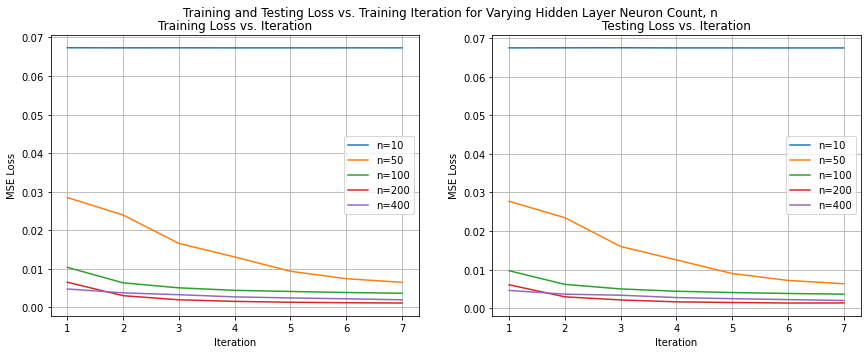

In [22]:
results = np.asarray(results)
f, (pl1, pl2) = plt.subplots(1,2)
for n_idx in range(results.shape[0]):
    pl1.plot(np.asarray(list(range(results.shape[2])))+1,results[n_idx][0],label=f"n={layers[n_idx]}")
    pl2.plot(np.asarray(list(range(results.shape[2])))+1,results[n_idx][1],label=f"n={layers[n_idx]}")
f.suptitle("Training and Testing Loss vs. Training Iteration for Varying Hidden Layer Neuron Count, n",x=1.05,y=1.2)
f.subplots_adjust(right=2,top=1.1)
pl1.set(title="Training Loss vs. Iteration",xlabel="Iteration",ylabel="MSE Loss")
pl1.legend()
pl1.grid()
pl2.set(title="Testing Loss vs. Iteration",xlabel="Iteration",ylabel="MSE Loss")
pl2.legend()
pl2.grid()

The 200 neuron Encoder exhibited the lowest error without any indication of overfitting.


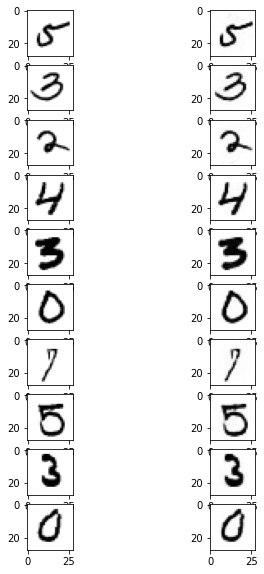

In [23]:
print("The 200 neuron Encoder exhibited the lowest error without any indication of overfitting.")
idxs = torch.multinomial(torch.Tensor(range(x_test_tensor.shape[0])),10)
f, ((pl1, pl2), (pl3, pl4), (pl5, pl6), (pl7, pl8), (pl9, pl10), (pl11, pl12), (pl13, pl14), (pl15, pl16), (pl17, pl18), (pl19, pl20)) = plt.subplots(10,2)
pls = [pl1, pl2, pl3, pl4, pl5, pl6, pl7, pl8, pl9, pl10, pl11, pl12, pl13, pl14, pl15, pl16, pl17, pl18, pl19, pl20]
pl_i = 0
for i in idxs:
    pls[pl_i].imshow(x_test_tensor[i,:].reshape((28,28)),cmap='gray_r')
    pl_i += 1
    pls[pl_i].imshow(nets[3].forward(x_test_tensor[i,:]).detach().numpy().reshape((28,28)),cmap='gray_r')
    pl_i += 1

f.subplots_adjust(top=2)

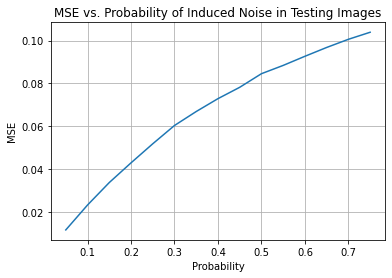

In [24]:
def autoenc_corrupt(input_imgs, p):
    fresh_batch = copy.deepcopy(input_imgs)
    for idx in range(input_imgs.shape[0]):
        idxs_noise = torch.multinomial(torch.Tensor(range(784)), int(784*p))
        fresh_batch[idx,idxs_noise[:idxs_noise.shape[0]//2]] = 0
        fresh_batch[idx,idxs_noise[idxs_noise.shape[0]//2:]] = 1
    return fresh_batch
        
ps = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75]
err_noisy = np.zeros_like(ps)

for p_idx,p in enumerate(ps):
    for _ in range(5):
        noisy_testing = autoenc_corrupt(x_test_tensor[138:250,:],p) # arbitrary images from test tensor
        for im_idx in range(noisy_testing.shape[0]):
            recon = nets[3].forward(noisy_testing[im_idx])
            err_noisy[p_idx] += mse(x_test_tensor[138 + im_idx,:],recon) / (5 * noisy_testing.shape[0])

f, pl1 = plt.subplots(1,1)
pl1.plot(ps,err_noisy)
pl1.set(title="MSE vs. Probability of Induced Noise in Testing Images",xlabel="Probability",ylabel="MSE")
pl1.grid()

**3.2 [1 Mark]** Described what you've observed about the results of the autoencoder, compared to the Hopfield networks.

The results of the autoencoder are substantially more representative than those of the Hopfield networks. Whereas the Hopfield networks try to direct the input image into some stored pattern(s), the autoencoder seems capable of storing the essential features and reconstructing the image independent from any internally stored "patterns". We also observe that the autoencoder is more robust against noise than the Hopfield networks explored previously.

**3.3 [1 Marks]** Sensory Preconditioning - Now we are going to look at small datasets. We are going to use the sensory preconditioning protocol, discussed by Gluck and Meyers.

We will also need to construct a data set that performs the preconditioning.  We will break this down into three phases:

1. Do the sensory preconditioning.  Plot the training loss vs number of epochs, describe the resultant behaviour.

In [25]:
torch.manual_seed(123456)
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:
        
        # Output of Autoencoder
        reconstructed = model(inp)
    
        # Calculating the loss function
        loss = loss_function(reconstructed, out)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass 

We see a complete collapsing of training loss, indicating that the model is theoretically perfectly fit to the input stimulus and response data


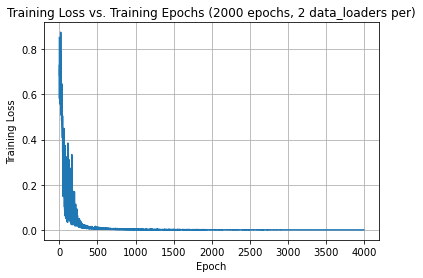

In [26]:
f, pl1 = plt.subplots(1,1)
pl1.plot(losses)
pl1.set_title("Training Loss vs. Training Epochs (2000 epochs, 2 data_loaders per)")
pl1.set_xlabel("Epoch")
pl1.set_ylabel("Training Loss")
pl1.grid()
print("We see a complete collapsing of training loss, indicating that the model is theoretically perfectly fit to the input stimulus and response data")

2. Train the conditioned response to one stimulus.  We will train this using simple linear regression where we map the the hidden state to the desired output.  You can reuse the linear regression code (```pseudo_inv```) from above.

You will be learning a mapping from the hidden state of the autoencoder to the conditioning stimuli.

Lets call the features (columns) of the stimuli data as s1, s2, c1, and c2.

In [27]:
conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
conditioning_outputs = torch.from_numpy(np.array([[0,0,0,0,1,1,1,1]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

def get_weights(features, values, lamb=0.001):
    ps_inv = torch.inverse(features.T@features + lamb * torch.eye(features.shape[1]).float()) @ (features.T @ values)
    W = ps_inv
    return W

def evaluate(weights, features):
    return features @ weights

W = get_weights(conditioning_features, conditioning_outputs)
conditioned_response = evaluate(W, conditioning_features[4:,:])
print(conditioned_response)

tensor([[1.3165],
        [0.9703],
        [0.7159],
        [0.3881]], grad_fn=<MmBackward0>)


3. Report the strength of the conditioned response to the other stimulus.  Has the network transferred learning from one stimuls to the other?

In [28]:
test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)

transferred_response = evaluate(W, testing_features)
print(transferred_response)
print("It certainly appears that the conditioned response from S1 has transferred into the response of S2 -- the values appear to be fairly similar")

tensor([[1.3190],
        [0.9733],
        [0.7192],
        [0.3905]], grad_fn=<MmBackward0>)
It certainly appears that the conditioned response from S1 has transferred into the response of S2 -- the values appear to be fairly similar


4. Compare to the response of the system without either of the preconditioned inputs

In [29]:
unconditioned_responses = evaluate(W, conditioning_features[:4,:])
print(unconditioned_responses)
print("The unconditioned responses are distinct from the conditioned responses with much smaller, and even negative, values making an appearance")

tensor([[-0.1055],
        [-0.1812],
        [ 0.0739],
        [ 0.0004]], grad_fn=<MmBackward0>)
The unconditioned responses are distinct from the conditioned responses with much smaller, and even negative, values making an appearance


5. Plot graphs showing the strength of the response to the conditioned stimuli, the pre-conditioned stimuli, and the unconditioned stimuli
(*i.e.*, s1 = 0, s2 = 0, and context in $\{(0,0),(0,1),(1,0),(1,1)\}$)

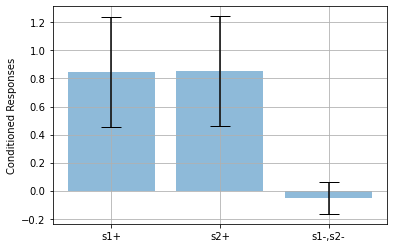

In [30]:
response_mu = torch.Tensor([torch.mean(conditioned_response), torch.mean(transferred_response), torch.mean(unconditioned_responses)])
response_std = torch.Tensor([torch.std(conditioned_response), torch.std(transferred_response), torch.std(unconditioned_responses)])

f, ax = plt.subplots()
ax.bar([1,2,3], response_mu, yerr=response_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3], labels=['s1+', 's2+', 's1-,s2-'])
ax.grid()

**[BONUS]** [1 Mark] Repeat the sensory preconditioning, but use an conditioning stimulus that is not 100\% correlated with the unconditioned stimulus. That is: change phase 2 so that it is not possible to perfectly predict the output.

Following this setup, we see a decrease in the strength of conditioned and pre-conditioned responses and an increase in the strength of the unconditioned responses.
      This is likely attributable to the inability of the stimuli to perfectly associate to the conditioned output.


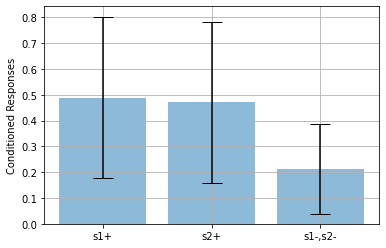

In [31]:
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:
        
        # Output of Autoencoder
        reconstructed = model(inp)
    
        # Calculating the loss function
        loss = loss_function(reconstructed, out)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass 

conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
# Shift conditioned responses to not align with any particular simulus
conditioning_outputs = torch.from_numpy(np.array([[0,0,1,1,1,1,0,0]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

W = get_weights(conditioning_features, conditioning_outputs)
conditioned_response = evaluate(W, conditioning_features[4:,:])

test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)
transferred_response = evaluate(W, testing_features)

unconditioned_responses = evaluate(W, conditioning_features[:4,:])

response_mu = torch.Tensor([torch.mean(conditioned_response), torch.mean(transferred_response), torch.mean(unconditioned_responses)])
response_std = torch.Tensor([torch.std(conditioned_response), torch.std(transferred_response), torch.std(unconditioned_responses)])

f, ax = plt.subplots()
ax.bar([1,2,3], response_mu, yerr=response_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3], labels=['s1+', 's2+', 's1-,s2-'])
ax.grid()

print('''Following this setup, we see a decrease in the strength of conditioned and pre-conditioned responses and an increase in the strength of the unconditioned responses.
      This is likely attributable to the inability of the stimuli to perfectly associate to the conditioned output.''')